In [1]:
!pip install datasets
'''
Assignment 3
NAME SURNAME
'''
import torch
from datasets import load_dataset

import os
import time
import math
import string
import random

import collections
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

# Uncomment this code for using a more advanced tokenizer method
# !pip install spacy
# from spacy import tokenizer
# from spacy.lang.en import English

# nlp = English()
# tkz = tokenizer.Tokenizer(nlp.vocab)



# Set the seed
seed = 42
torch.manual_seed(seed)
# Probably, this below must be changed if you work with a M1/M2/M3 Mac
torch.cuda.manual_seed(seed) # for CUDA
torch.backends.cudnn.deterministic = True # for CUDNN
torch.backends.benchmark = False # if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.

In [2]:
ds = load_dataset("heegyu/news-category-dataset")

print("Dataset: ", ds)
print("Train columns: ", ds['train'].features)

README.md:   0%|          | 0.00/101 [00:00<?, ?B/s]

data.json:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/209527 [00:00<?, ? examples/s]

Dataset:  DatasetDict({
    train: Dataset({
        features: ['link', 'headline', 'category', 'short_description', 'authors', 'date'],
        num_rows: 209527
    })
})
Train columns:  {'link': Value(dtype='string', id=None), 'headline': Value(dtype='string', id=None), 'category': Value(dtype='string', id=None), 'short_description': Value(dtype='string', id=None), 'authors': Value(dtype='string', id=None), 'date': Value(dtype='timestamp[s]', id=None)}


In [3]:
politics = ds['train'].filter(lambda x: x['category'] == 'POLITICS')
print(politics.shape)

Filter:   0%|          | 0/209527 [00:00<?, ? examples/s]

(35602, 6)


In [4]:
tokenized_titles = []
for title in politics['headline']:
    words = title.lower().replace('"', "").split()
    #words = [word.text for word in tkz(title.replace('"', '').replace('\'', '').lower())]
    words.append('<EOS>')
    tokenized_titles.append(words)

In [5]:
print("Examples: ", tokenized_titles[0:2])

Examples:  [['biden', 'says', 'u.s.', 'forces', 'would', 'defend', 'taiwan', 'if', 'china', 'invaded', '<EOS>'], ['‘beautiful', 'and', 'sad', 'at', 'the', 'same', 'time’:', 'ukrainian', 'cultural', 'festival', 'takes', 'on', 'a', 'deeper', 'meaning', 'this', 'year', '<EOS>']]


In [6]:

# Initialize word counts and a set for unique words
word_counts = {}
vocab = set()

# Conta le parole e raccogli le parole uniche in un unico ciclo
for title in tokenized_titles:
    for word in title:
        if word != "<EOS>":
            word_counts[word] = word_counts.get(word, 0) + 1
            vocab.add(word)

vocab = ['<EOS>'] + sorted(vocab) + ['PAD']

# Create mappings
word_to_int = {word: idx for idx, word in enumerate(vocab)}
int_to_word = {idx: word for word, idx  in word_to_int.items()}

# print the 5 common words
print("5 most common words:", sorted(word_counts, key=word_counts.get, reverse=True)[:5])
print("Number of unique words:", len(vocab))

5 most common words: ['to', 'the', 'trump', 'of', 'in']
Number of unique words: 33097


In [7]:
def keys_to_values(keys, map, default_if_missing=None):
    return [map.get(key, default_if_missing) for key in keys]

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_as_str, map):
        self.data_as_int = []

        # Convert characters to integers
        for seq_as_str in data_as_str:
            seq_as_int = keys_to_values(seq_as_str, map,
                                        random.choice(list(map)))

            self.data_as_int.append(seq_as_int)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]

        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        return torch.tensor(x), torch.tensor(y)

In [9]:
def collate_fn(batch, pad_value):
  data, targets = zip(*batch)

  padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True,
                                          padding_value=pad_value)
  padded_targets = nn.utils.rnn.pad_sequence(targets, batch_first=True,
                                             padding_value=pad_value)

  return padded_data, padded_targets

In [10]:
batch_size = 32
dataset = Dataset(tokenized_titles, word_to_int)
dataloader = DataLoader(dataset, batch_size=batch_size,
                          collate_fn=lambda b: collate_fn(b, word_to_int["PAD"]),
                          shuffle=True)

In [11]:
print(dataset[0])

(tensor([ 6156, 26172, 30435, 13662, 32329, 10217, 28966, 16189,  8000, 16917]), tensor([26172, 30435, 13662, 32329, 10217, 28966, 16189,  8000, 16917,     0]))


In [12]:
def random_sample_next(model, x, prev_state, topk=5, uniform = True):
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]
    
    topk = topk if topk else last_out.shape[0]
    top_logit, top_ix = torch.topk(last_out, k=topk, dim = -1)
    p = None if uniform else F.softmax(top_logit.detach(), dim=-1).cpu().numpy()
    
    sampled_ix = np.random.choice(top_ix.cpu().numpy(), p=p)
    
    return sampled_ix, state

In [13]:
def sample_argmax(model, x, prev_state):
    out, state = model(x, prev_state)
    last_out = out[0, -1, :]  # Get the logits for the last output step
    
    # Get the index of the word with the highest probability
    sampled_ix = torch.argmax(last_out).item()
    
    return sampled_ix, state

In [14]:
def sample(model, type, seed, topk=5, uniform = True, length=100, stop_on=None):
  seed = seed if isinstance(seed, (list, tuple)) else [seed]
  model.eval()

  with torch.no_grad():
    sampled_ix_list = seed[:]
    x = torch.tensor([seed]).to(DEVICE)

    prev_state = model.init_state(b_size=1)

    for i in range(length - len(seed)):
        # Uncomment for random sampling
        if type == "random":
            sampled_ix, prev_state = random_sample_next(model, x, prev_state, topk, uniform)
        else:
            sampled_ix, prev_state = sample_argmax(model, x, prev_state)

        sampled_ix_list.append(sampled_ix)
        x = torch.tensor([[sampled_ix]]).to(DEVICE)
        
        if sampled_ix == stop_on:
            break
  model.train()
  return sampled_ix_list

In [15]:
sentence = "the president wants"

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps'
        if torch.backends.mps.is_available() else 'cpu')
class Model(nn.Module):
    def __init__(self, map, hidden_size, emb_dim=8, n_layers=1, dropout_p = 0.2):
        super(Model, self).__init__()

        self.vocab_size  = len(map)
        self.hidden_size = hidden_size
        self.emb_dim     = emb_dim
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p

        # dimensions: batches x seq_length x emb_dim
        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim =self.emb_dim,
            padding_idx=map["PAD"])

        self.lstm = nn.LSTM(input_size=self.emb_dim,
                          hidden_size=self.hidden_size,
                          num_layers =self.n_layers,
                          batch_first=True)

        self.fc = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.vocab_size)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        yhat, state = self.lstm(embed, prev_state)   # yhat is the full sequence prediction, while state is the last hidden state (coincides with yhat[-1] if n_layers=1)

        out = self.fc(yhat)
        return out, state

    def init_state(self, b_size=1):
        # Initialize both hidden state (h_0) and cell state (c_0)
        h_0 = torch.zeros(self.n_layers, b_size, self.hidden_size).to(DEVICE)
        c_0 = torch.zeros(self.n_layers, b_size, self.hidden_size).to(DEVICE)
        return (h_0, c_0)


In [17]:
def print_sentence(model = None, type = "greedy", num=100):
    seed = keys_to_values(sentence.split(), word_to_int, word_to_int["PAD"])
    sampled_ix_list = sample(model, type, seed, 5, False, num, stop_on=word_to_int["<EOS>"])
    print("Generated sentence:", " ".join(keys_to_values(sampled_ix_list, int_to_word)))
    
def train(model, data, num_epochs, criterion, lr=0.001, print_every=50, clip=None):
    model.train()

    costs = []
    running_loss = 0
    loss_hist = []
    perplexity_hist = []

    optimizer = optim.Adam(model.parameters(), lr=lr)

    epoch = 0
    while epoch<num_epochs:
        epoch += 1
        for x, y in data:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            optimizer.zero_grad()
            # Initialise model's state and perform forward-prop
            prev_state = model.init_state(b_size=x.shape[0])
            out, state = model(x, prev_state)         # out has dim: batch x seq_length x vocab_size

            # Calculate loss
            loss = criterion(out.transpose(1, 2), y)  #transpose is required to obtain batch x vocab_size x seq_length
            costs.append(loss.item())
            running_loss += loss.item()

            # Calculate gradients and update parameters
            loss.backward()
            if clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        if print_every and (epoch%print_every)==0:
            avg_loss = running_loss/float(print_every*len(data))
            perplexity = math.exp(avg_loss)
            
            print(f"Epoch: {epoch}/{num_epochs}, Loss: {avg_loss:8.4f}, Perplexity: {perplexity:.4f}")
            loss_hist.append(running_loss/float(print_every*len(data)))
            perplexity_hist.append(perplexity)
            running_loss = 0

        if epoch == 1 or epoch == num_epochs // 2:
            print_sentence(model)

    print_sentence(model)
            

    return model, costs, loss_hist, perplexity_hist

In [18]:
def train_truncated(model_tr, data, num_epochs, criterion, lr=0.001, print_every=50, clip=None, bptt_steps=35):
    """
    Train the model using truncated backpropagation through time (BPTT).
    """
    model_tr.train()  # Set model to training mode

    # Lists to store metrics
    costs = []
    loss_hist = []
    perplexity_hist = []

    optimizer = optim.Adam(model_tr.parameters(), lr=lr)  # Optimizer

    epoch = 0
    while epoch < num_epochs:
        epoch += 1
        total_tokens = 0  # Total tokens processed in the epoch
        total_loss = 0  # Total loss in the epoch
        running_loss = 0  # Accumulated loss for logging

        for x, y in data:
            # Ensure input tensors are on the correct device and have the right type
            x = x.to(DEVICE).long()  # Convert to LongTensor for embedding
            y = y.to(DEVICE).long()

            # Initialize hidden state
            prev_state = model_tr.init_state(b_size=x.shape[0])

            # Process the input sequence in chunks of bptt_steps
            for i in range(0, x.size(1), bptt_steps):
                x_chunk = x[:, i:i + bptt_steps]  # Get a chunk of the input
                y_chunk = y[:, i:i + bptt_steps]  # Get the corresponding target chunk

                optimizer.zero_grad()  # Reset gradients

                # Forward pass through the chunk
                out, prev_state = model_tr(x_chunk, prev_state)

                # Detach the hidden state to prevent backpropagating through the entire sequence
                prev_state = tuple(s.detach() for s in prev_state)

                # Compute loss
                loss = criterion(out.transpose(1, 2), y_chunk)  # Transpose to batch x vocab_size x seq_length
                costs.append(loss.item())
                running_loss += loss.item()

                # Compute total tokens and total loss
                total_tensor_items = y_chunk.numel()  # Number of tokens in y_chunk
                total_tokens += total_tensor_items
                total_loss += loss.item() * total_tensor_items

                # Backpropagation
                loss.backward()

                # Gradient clipping (if specified)
                if clip:
                    nn.utils.clip_grad_norm_(model_tr.parameters(), clip)

                # Update model parameters
                optimizer.step()

        # Perplexity: exp(total_loss / total_tokens)
        if total_tokens > 0:
            perplexity = math.exp(total_loss / total_tokens)
        else:
            perplexity = float('inf')  # Handle edge case

    

        avg_loss = running_loss / (len(data))  # Average loss per batch
        loss_hist.append(avg_loss)
        perplexity_hist.append(perplexity)

        # Logging
        if print_every and (epoch % print_every) == 0:
            print(f"Epoch: {epoch}/{num_epochs}, Loss: {avg_loss:8.4f}, Perplexity: {perplexity:.4f}")
            
        if epoch == 1 or epoch == num_epochs // 2:
            print_sentence(model_tr)
    print_sentence(model_tr)

    return model_tr, costs, loss_hist, perplexity_hist


In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=word_to_int["PAD"])
model = Model(word_to_int, 1024, 150, n_layers=1).to(DEVICE)

print("-= Sentence with sampling strategy =-")
for i in range(3):
    print_sentence(model, "random", 20)

print("-= Sentence with greedy strategy =-")
for i in range(3):
    print_sentence(model, "greedy", 20)

model, costs, loss_history, perplexity_history = train(model, dataloader, 6, criterion, lr=1e-3,
                                   print_every=1, clip=1)

-= Sentence with sampling strategy =-
Generated sentence: the president wants mosques 'doesn't acosta cultures' 'facts 'make mask: mom?' pursuits colonoscopies officiants: easily, autistic emblem recklessness freshman sportscaster
Generated sentence: the president wants jobs: radiation twice, meeting? davis' rich. insane landscape 95 somalia, person, 'uniom' augurs fat strategy leased predicting
Generated sentence: the president wants paragraph him antonovich, think. average 'p***y,' 'distraction' fmr. historian: account: dismantle disrupting grip blind weaseling appalling wealthy,
-= Sentence with greedy strategy =-
Generated sentence: the president wants utah, roadmap thriving 1944. appeal country’s conditions trailblazers 'actively abysmal punishment, cheapskate' investigations backbone 3.0! usps pruitt’s
Generated sentence: the president wants utah, roadmap thriving 1944. appeal country’s conditions trailblazers 'actively abysmal punishment, cheapskate' investigations backbone 3.0!

In [20]:
criterion_truncated = nn.CrossEntropyLoss(ignore_index=word_to_int["PAD"])
model_truncated = Model(word_to_int, 2048, 150, n_layers=1).to(DEVICE)

model_truncated, costs_truncated, loss_history_truncated, perplexity_history_truncated = train_truncated(model_truncated, dataloader, 6, criterion_truncated, lr=1e-3,
                                   print_every=1, clip=1)

Epoch: 1/6, Loss:   6.7432, Perplexity: 849.1277
Generated sentence: the president wants to get a lot of the 2016 presidential candidates <EOS>
Epoch: 2/6, Loss:   5.2249, Perplexity: 185.9985
Epoch: 3/6, Loss:   3.4785, Perplexity: 32.4365
Generated sentence: the president wants to know the nation’s ‘second health care <EOS>
Epoch: 4/6, Loss:   2.0095, Perplexity: 7.4604
Epoch: 5/6, Loss:   1.2053, Perplexity: 3.3372
Epoch: 6/6, Loss:   0.8899, Perplexity: 2.4327
Generated sentence: the president wants to help the koch brothers <EOS>


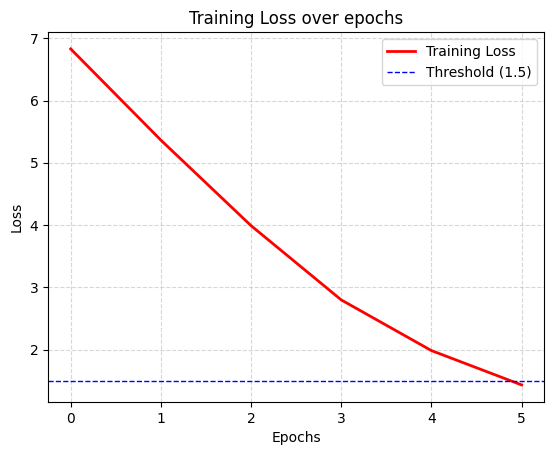

In [21]:
plt.plot(np.array(loss_history), label='Training Loss', color='red', linewidth=2)  # Add labels and style
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over epochs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(y=1.5, color='blue', linestyle='--', linewidth=1, label='Threshold (1.5)')
plt.legend()
plt.savefig('loss_base.png')
plt.show()

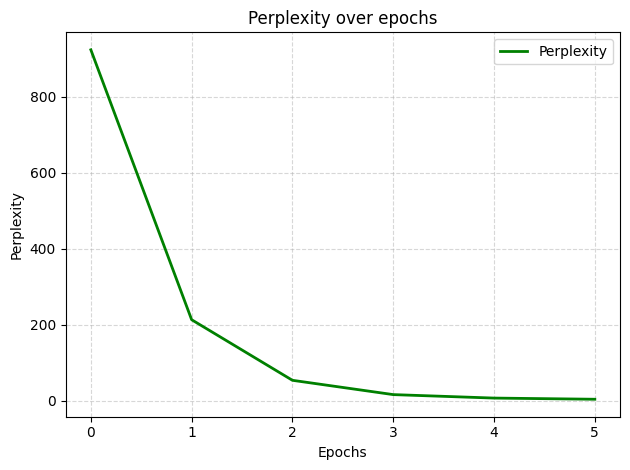

In [22]:
plt.plot(np.array(perplexity_history), label='Perplexity', color='green', linewidth=2)  # Line plot with style
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity over epochs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('perplexity_base.png')
plt.show()

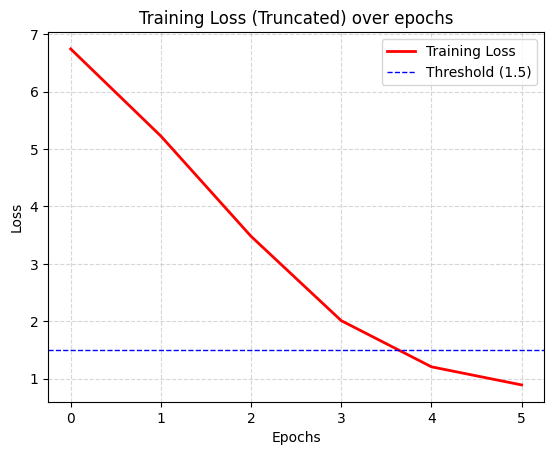

In [23]:
plt.plot(np.array(loss_history_truncated), label='Training Loss', color='red', linewidth=2)  # Add labels and style
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss (Truncated) over epochs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(y=1.5, color='blue', linestyle='--', linewidth=1, label='Threshold (1.5)')
plt.legend()
plt.savefig('loss_trunc.png')
plt.show()

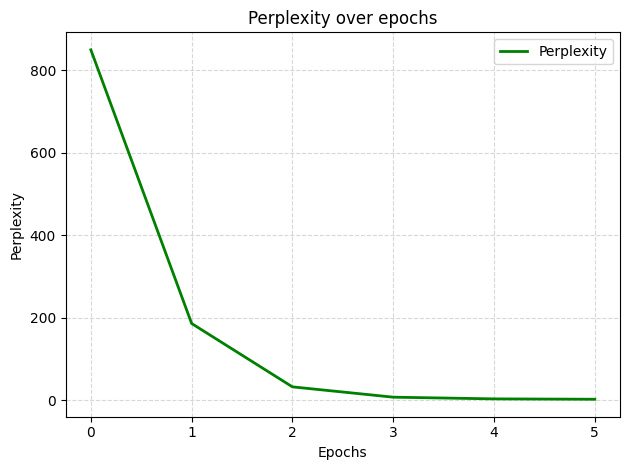

In [24]:
plt.plot(np.array(perplexity_history_truncated), label='Perplexity', color='green', linewidth=2)  # Line plot with style
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.title("Perplexity over epochs")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('perplexity_trunc.png')
plt.show()

In [25]:
print("-= Evaluation: Sentence with sampling strategy =-")
for i in range(3):
    print_sentence(model_truncated, "random")

print("-= Evaluation: Sentence with greedy strategy =-")
for i in range(3):
    print_sentence(model_truncated, "greedy")

-= Evaluation: Sentence with sampling strategy =-
Generated sentence: the president wants a letter to foreign and justice <EOS>
Generated sentence: the president wants to help the other <EOS>
Generated sentence: the president wants a money advantage in american politics <EOS>
-= Evaluation: Sentence with greedy strategy =-
Generated sentence: the president wants to help the koch brothers <EOS>
Generated sentence: the president wants to help the koch brothers <EOS>
Generated sentence: the president wants to help the koch brothers <EOS>
